In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pycomlink as pycml

# Read in example data from one CML 

In [3]:
cml = pycml.io.examples.read_one_cml()

1 CMLs read in


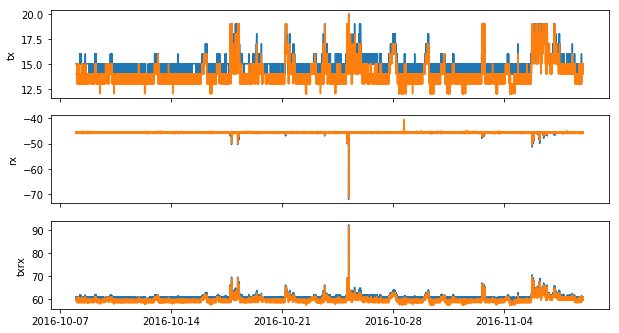

In [4]:
# Remove artifacts and plot data
cml.process.quality_control.set_to_nan_if('tx', '>=', 100)
cml.process.quality_control.set_to_nan_if('rx', '==', -99.9)

cml.plot_data(['tx', 'rx', 'txrx']);

# Do a simple wet/dry classification

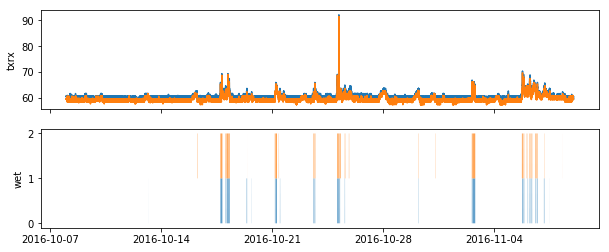

In [5]:
cml.process.wet_dry.std_dev(window_length=30, threshold=0.8)
cml.plot_data(['txrx', 'wet']);

# Derive a constant baseline
Let's just focus on the rain events on 2016-10-25

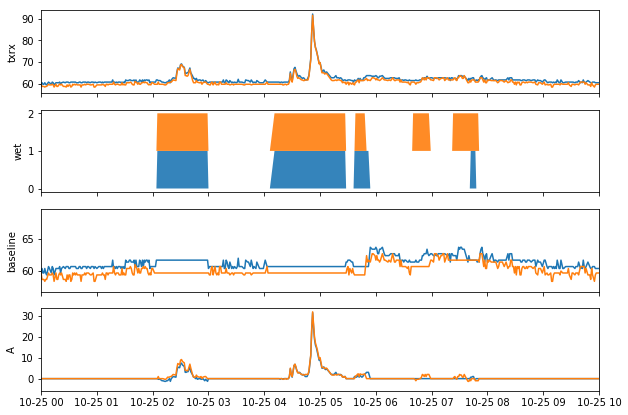

In [6]:
cml.process.baseline.constant()
cml.process.baseline.calc_A()
ax = cml.plot_data(['txrx', 'wet', 'baseline', 'A']);
ax[0].set_xlim('2016-10-25 00:00', '2016-10-25 10:00');

In [7]:
# Save a copy of these results for comparing them to the linear baseline later
baseline_constant = cml.channel_1.data.baseline.copy()
A_constant = cml.channel_1.data.A.copy()

# Or derive a linear baseline 

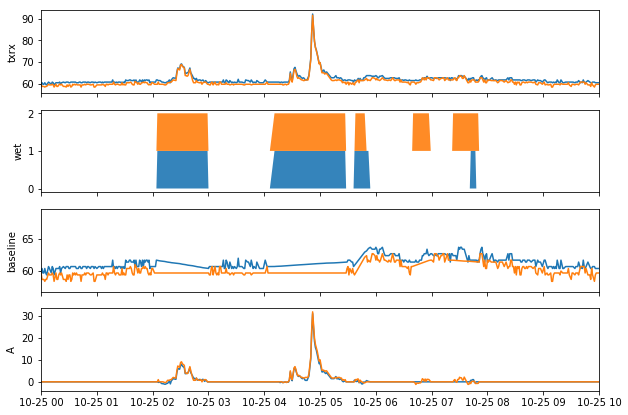

In [8]:
cml.process.baseline.linear()
cml.process.baseline.calc_A()
ax = cml.plot_data(['txrx', 'wet', 'baseline', 'A']);
ax[0].set_xlim('2016-10-25 00:00', '2016-10-25 10:00');

In [9]:
# Save a copy of these results for comparing them to the constant baseline
baseline_linear = cml.channel_1.data.baseline.copy()
A_linear = cml.channel_1.data.A.copy()

# Compare the results from constant and linear baseline

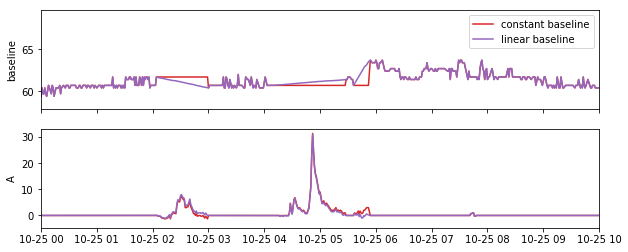

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

ax[0].plot(baseline_constant, color='C3', label='constant baseline')
ax[0].plot(baseline_linear, color='C4', label='linear baseline')

ax[1].plot(A_constant, color='C3', label='constant baseline')
ax[1].plot(A_linear, color='C4', label='linear baseline')

ax[0].set_xlim('2016-10-25 00:00', '2016-10-25 10:00');

ax[0].set_ylabel('baseline')
ax[1].set_ylabel('A')

ax[0].legend();

# NaN handling

The algorithms for constant and linear baseline handle `NaN`s differently:
* constant baseline:
    * For `NaN` values in `wet` the `baseline` is also set to `NaN`.
    * All `baseline` values following a `NaN` during a wet event are also set to `NaN` till the next dry event starts. This has to be done, since we do not know if a new wet event started during a `NaN` period and hence we do not know at which level the constant baseline should be.
* linear baseline:
    * Default:  
    The `baseline` for a whole wet event is set to `NaN` if there is at least one `wet` `NaN` within this period. This makes sense, since for the interpolation of the linear baseline the correct end of the wet period has to be known to its `txrx` value. Since the wet event could have ended during the `NaN` period, we do not know the end of the wet period and hence cannot savely assume a `txrx` endpoint for the interpolation.
    * Option to `ignore_nan`:  
    If you know what you are doing, e.g. because you know that your only have very few consecutive `wet` `NaN`s and hecne can assume that a wet event will not stop during your `wet` `NaN`, then you can ignore all `NaN`s. This will take the next switch from wet to dry as endpoint of the wet event and do the interpolation accordingly.

In [11]:
# Exchange the current `wet` pd.Series in `channel_1` with a different series of floats with some `NaN`s
wet_temp = cml.channel_1.data.wet.astype(float)
wet_temp['2016-10-25 04:45': '2016-10-25 05:00'] = np.NaN
cml.channel_1.data.wet = wet_temp

## Constant baseline

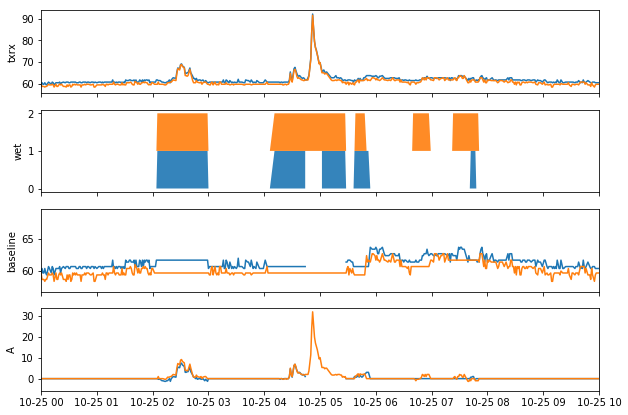

In [12]:
cml.process.baseline.constant()
cml.process.baseline.calc_A()
ax = cml.plot_data(['txrx', 'wet', 'baseline', 'A']);
ax[0].set_xlim('2016-10-25 00:00', '2016-10-25 10:00');

# Linear baseline (default)
default = set `baseline` for whole wet event to `NaN` if it contains at least one `wet` `NaN`

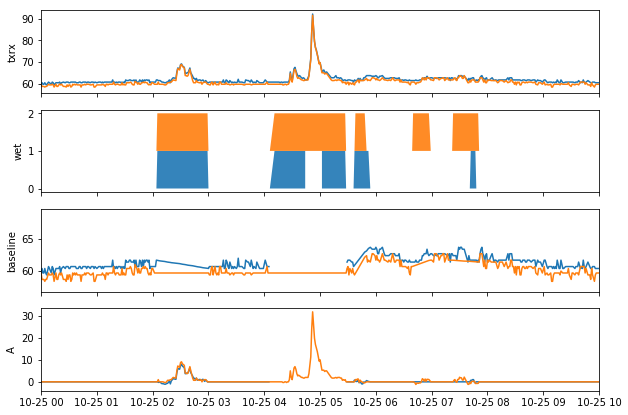

In [13]:
cml.process.baseline.linear()
cml.process.baseline.calc_A()
ax = cml.plot_data(['txrx', 'wet', 'baseline', 'A']);
ax[0].set_xlim('2016-10-25 00:00', '2016-10-25 10:00');

## Linear baseline (ignoring `NaN`s)

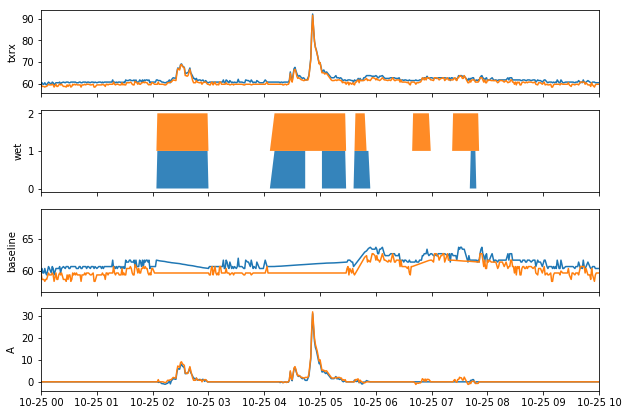

In [14]:
cml.process.baseline.linear(ignore_nan=True)
cml.process.baseline.calc_A()
ax = cml.plot_data(['txrx', 'wet', 'baseline', 'A']);
ax[0].set_xlim('2016-10-25 00:00', '2016-10-25 10:00');